# Masking and stacking a MaNGA datacube
This notebook deals with fetching data from SDSS' database through Marvin, correcting for galactic reddening, applying masks that remove low signal , faulty and non-PSB spaxels, then stack the data and save out the resulting stacked spectrum.

Procedures will likely be different for WEAVE but at least this should be a good enough guidiance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import marvin
from astropy.io import fits
import pandas as pd
from PyAstronomy import pyasl

[INFO]: No release version set. Setting default to DR17
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject (RuntimeWarning)


### For my work, the list of PSB candidates were created by Vivienne by running the selection in Chen+2019 on all of MaNGA DR17. So I only have a txt file with the list of candidates and their individual PSB spaxel maps. For this demo, I will start with one galaxy that is classified as a central PSB from Vivienne's run

In [2]:
plateifu = "8555-3701"
path_to_PSB_maps = "../../MaNGA_DR17/CPSBsample_maps"

In [4]:
# setup functions
class galaxy:

    def __init__(self, plateifu, map_folder):
        self.plateifu = plateifu
        # get the manga maps to count no. of spaxels with good data
        self.maps = marvin.tools.Maps(plateifu, release='DR17')
        if self.maps.mode == 'remote':
            self.maps.download()
        # use the Halpha quality mask for spaxel quality
        self.ha_qual = self.maps['emline_gflux_ha_6564']
        # PSB spaxel map provided by Vivienne
        map_file = f"{map_folder}/{plateifu}_PSBmap.fits"
        hdul = fits.open(map_file)
        self.PSB_map = hdul[0].data
        hdul.close()
    
    def get_good_spaxel_no(self):
        lowcov = self.ha_qual.pixmask.get_mask('LOWCOV')
        nocov = self.ha_qual.pixmask.get_mask('NOCOV')
        donotuse = self.ha_qual.pixmask.get_mask('DONOTUSE')
        bad_pix = ( (nocov) | (lowcov) | (donotuse))
        good_spaxel_no = np.sum(bad_pix==0)
        return good_spaxel_no
        
    def prep_cube(self):
        # first get all relevent both DRP and DAP cubes
        self.DRPcube = marvin.tools.Cube(self.plateifu, release='DR17')
        if self.DRPcube.mode == 'remote':
            self.DRPcube.download()
        self.DAPcube = marvin.tools.ModelCube(self.plateifu)
        if self.DAPcube.mode == 'remote':
            self.DAPcube.download()

        # extract the masks from Halpha qual mask
        nocov = self.ha_qual.pixmask.get_mask('NOCOV')
        lowcov = self.ha_qual.pixmask.get_mask('LOWCOV')
        donotuse = self.ha_qual.pixmask.get_mask('DONOTUSE')
        deadfiber = self.ha_qual.pixmask.get_mask('DEADFIBER')
        forestar = self.ha_qual.pixmask.get_mask('FORESTAR')
        qualmask_ = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )
        self.qualmask = (qualmask_==0)
        
        # Milky way reddening correction
        self.cube_redcorr = self.DAPcube._redcorr
        cube_redcorr_ = self.cube_redcorr[:,np.newaxis,np.newaxis]
        self.corrected_flux = self.DRPcube.flux.value*cube_redcorr_
        self.corrected_ivar = self.DRPcube.flux.ivar/cube_redcorr_**2
        
        # binned = voronoi binned (DAP cube)
        self.binned_corrected_flux = self.DAPcube.binned_flux.value*cube_redcorr_
        self.binned_corrected_ivar = self.DAPcube.binned_flux.ivar/cube_redcorr_**2
        
        # SNR calculations
        self.snr = np.mean(self.DRPcube.flux.snr,axis=0)
        self.binned_snr = np.mean(self.DAPcube.binned_flux.snr,axis=0)
        
    def stack(self, binned=False, SNR_threshold=None, shift_to_vrest=False):
        if binned:
            wavelength = self.DAPcube.binned_flux.wavelength.value.copy()
            flux = self.binned_corrected_flux.copy()
            ivar = self.binned_corrected_ivar.copy()
            snr = self.binned_snr.copy()
            pixmask = self.DAPcube.binned_flux.mask.copy()
        else:
            wavelength = self.DRPcube.flux.wavelength.value.copy()
            flux = self.corrected_flux.copy()
            ivar = self.corrected_ivar.copy()
            snr = self.snr.copy()
            pixmask = self.DRPcube.flux.mask.copy()
            
        qualmask = self.qualmask.copy()
        
        self.PSB_mask = (self.PSB_map==1)
        
        if SNR_threshold is None:
            self.combined_mask = qualmask * self.PSB_mask
        else:
            self.combined_mask = qualmask * self.PSB_mask * (snr>SNR_threshold)
        
        self.wavelength, self.spectrum, self.errors = self.stacking(
            wavelength, flux, ivar, self.combined_mask, pixmask)
        
    def stacking(self, wavelength, flux, ivar, mask, pixmask):
        masked_flux = mask * flux
        
        # only stack the flux value if the spectral pixel is not masked
        # (pixmask==0), ivar is not zero and the whole spaxel is not
        # masked.
        # contribution_cube keeps track of this and also how many
        # spaxel is stacked for each pixel. 
        contribution_cube = np.zeros(np.shape(masked_flux))
        contribution_cube = mask * (1-(ivar==0)) * (pixmask==0)
        
        valid_pix_spectrum_cube = contribution_cube * masked_flux
        valid_pix_var_cube = np.where(contribution_cube==1, 1/ivar, 0)

        contribution_list = np.sum(contribution_cube, axis=(1,2))
        spectrum = np.sum(valid_pix_spectrum_cube, axis=(1,2)) \
                   *10**-17*max(contribution_list)/contribution_list
        errors = np.sqrt(np.sum(valid_pix_var_cube, axis=(1,2))) \
                 *10**-17*max(contribution_list)/contribution_list
        
        #dropping wavelength pixels that have summed error = 0
        zero_ind = np.where((errors==0)|(contribution_list==0)|(spectrum<=0))
        wavelength = np.delete(wavelength, zero_ind)
        spectrum = np.delete(spectrum, zero_ind)
        errors = np.delete(errors, zero_ind)
        
        return wavelength, spectrum, errors
        

In [6]:
gal = galaxy(plateifu, path_to_PSB_maps)

# get the number of spaxels that have good signal, and calculate the fraction of spaxels
# classified as PSB
# This is to remove galaxies with way too low PSB spaxel fractions
total_spaxel_no = gal.get_good_spaxel_no()
PSB_spaxel_no = np.sum(gal.PSB_map==1)
classifiable_spaxel_no = np.sum(abs(gal.PSB_map)>0)

if PSB_spaxel_no/total_spaxel_no > 0.05:
    print('passed')

passed


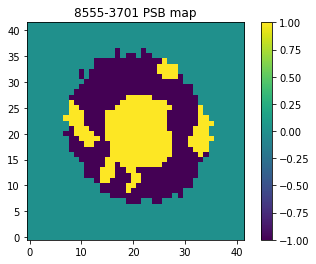

In [7]:
# make a plot of the PSB spaxels
plt.imshow(gal.PSB_map, origin='lower')
plt.colorbar()
plt.title(plateifu+' PSB map')
plt.show()

### At this point when working with a catalogue of galaxies, I will remove ones that have very asymmetrical or patchy PSB regions

### Get the SDSS 3 colour image for visual inspection of merger features

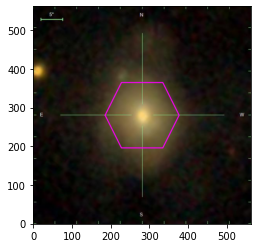

In [10]:
# get manga images
from marvin.tools.image import Image

im = Image(plateifu, release='DR17')
if im.mode == 'remote':
    im.download()
gal.image = im

plt.imshow(np.flip(gal.image.data, axis=0), origin='lower', aspect='equal')
plt.show()

### After looking at their SDSS images, I will remove ones with clear merger features, then use Marvin web version to remove ones with clear redshift mismatches (shows up as a clear shift in spectral lines in the fitted model in Marvin web), AGN broad bands, bright foreground stars and MaNGA cube bit warnings.

### Note:
We have considered shifting each spaxel to reverse the relative doppler effect using measured line-of-sight stellar velocity. However, it is unclear how we should stack the spaxels onto a unified wavelength grid after shifting, since they are all now on slightly different wavelength grids. Ultimately we decided to shelf this idea for later

In [11]:
# assuming this galaxy passed all the sample selection steps, now we stack it
# this step might take time to run if you have not downloaded the cubes before
gal.prep_cube()
# binned = True means to use the Voronoi binned flux from DAP cubes
# SNR_throshold sets the minimum SNR the spaxels need to have to be stacked. Currently set to None (0)
gal.stack(binned=False, SNR_threshold=None)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


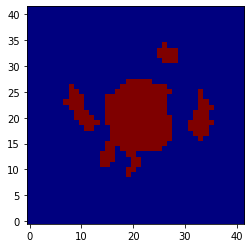

In [12]:
# make a plot of the spaxels that were stacked (red = in stack, blue = no)
plt.imshow(gal.combined_mask, origin='lower', cmap='jet', aspect='equal')
plt.show()

In [13]:
# load in skylines
np_arr = np.loadtxt('../../skylines.txt')
lines_air_df = pd.DataFrame(np_arr, columns=['wavelength', 'width', 'flux'])
lines_vac = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=5]['wavelength'])
print(lines_vac)

def mask_sky(wave, masksize=10):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask, np.array([lines-masksize, lines+masksize]).T

[ 5578.8954556   5891.59139941  5897.56609936  6302.05104962
  6365.54219491  7278.42940241  7318.30544998  7342.92338581
  7719.04633178  7752.78923803  7796.26537219  7823.67116968
  7855.68471156  7915.89486688  7966.84512414  7995.5325709
  8290.88675841  8301.18734197  8346.90679765  8401.48404869
  8401.48404869  8417.55479258  8432.43381448  8432.4934306
  8454.58820318  8467.55950967  8467.84078571  8763.74309991
  8770.33278231  8778.63192712  8780.75460129  8829.53629684
  8838.87572331  8870.04045417  8888.29629305  8905.56756572
  8922.08573476  8945.86366819  8960.41060417  8960.7133861
  8990.8514409   9003.60589215  9004.06401611  9308.56433224
  9309.93880434  9315.45979902  9315.90131855  9325.03859227
  9326.32113949  9340.43626093  9378.54917978  9422.33053404
  9442.25973032  9461.11933713  9479.49541313  9505.44193934
  9521.81647363  9522.1505641   9555.16730547  9569.73765144
  9570.23578635  9702.00297535  9722.50462876  9793.80124247
  9802.51450295  9851.19469

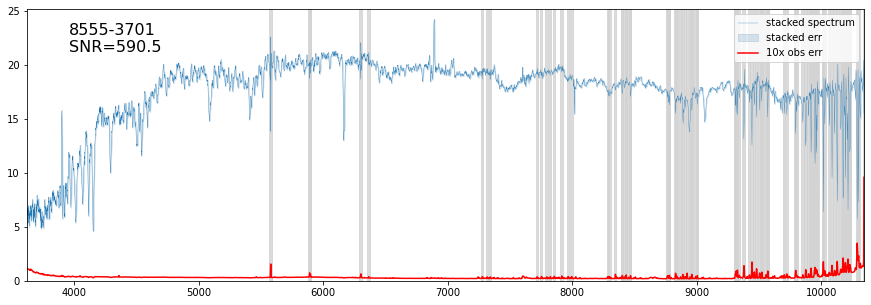

In [28]:
# plot the stacked spectrum
fig, ax = plt.subplots(figsize=[15,5])

# adjust y lims such that the masked portions of the spectrum do not drive the figure's y lims
spec_mask, mask_lims = mask_sky(gal.wavelength)
spec_masked = np.delete(gal.spectrum, spec_mask)
ylims = np.array([min(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000]),
                  max(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000])])*10**16
ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]

# stacked spectrum
ax.plot(gal.wavelength, gal.spectrum*10**16, lw=0.3, label='stacked spectrum')
# stacked errors
ax.fill_between(gal.wavelength, gal.spectrum*10**16-gal.errors*10**16, gal.spectrum*10**16+gal.errors*10**16,
                color='steelblue', alpha=0.2, label='stacked err')
# 10x stacked errors on the bottom
ax.plot(gal.wavelength, 10*gal.errors*10**16, color='r', label='10x obs err')
# skyline masks
for mask_lim_i in mask_lims:
    ax.fill_between(mask_lim_i, 0, ylims[1], color='lightgray', alpha=0.8)
    
ax.set_xlim(gal.wavelength[0],gal.wavelength[-1])
ax.set_ylim([0,ylims[1]])

# calculate average SNR
ave_SNR = np.mean(gal.spectrum/gal.errors)
ax.text(0.05,0.95, plateifu+'\nSNR='+str(np.round(ave_SNR,1)), transform=ax.transAxes,color='black', 
         ha='left', va='top', fontsize=16)
ax.legend()
plt.show()

In [29]:
import os
# Saving out the spectra
save_df = pd.DataFrame({'observed-wave[AA]':gal.wavelength.byteswap().newbyteorder(),
                    'flux[10^-16 erg/s/cm^2/AA]':gal.spectrum.byteswap().newbyteorder()*10**16, 
                    'noise[10^-16 erg/s/cm^2/AA]':gal.errors.byteswap().newbyteorder()*10**16})

save_name = 'MaNGA_spectrum/Spectrum_'+plateifu+'_PSBonly_dereddened.csv'
#save_df[save_df['observed-wave[AA]'].between(3000,9500)].to_csv(save_name, index=False)
if save_name.split('/')[1] not in os.listdir(save_name.split('/')[0]):
    print(save_name)
    save_df.to_csv(save_name, index=False)

MaNGA_spectrum/Spectrum_8555-3701_PSBonly_dereddened.csv
